In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from modelbase.ode import Model, Simulator, mca

Could not find GLIMDA.


In [2]:
import math

# Original rate equations:

$$\begin{eqnarray}
v_\mathrm{HK-PFK} &=& \frac{k_\mathrm{HK-PFK} \cdot ATP}{1+\left(\frac{ATP}{K_\mathrm{I,ATP}}\right)^{n_H}} \\
v_\mathrm{P2GM} &=& k_\mathrm{P2GM} \cdot P13G \\
v_\mathrm{P2Gase} &=& k_\mathrm{P2Gase} \cdot P23G \\
v_\mathrm{PGK} &=& k_\mathrm{PGK} \cdot P13G \cdot ADP \\
v_\mathrm{PK} &=& k_\mathrm{PK} \cdot PEP \cdot ADP \\
v_\mathrm{AK} &=& k^+_\mathrm{AK}\cdot AMP \cdot ATP - k^-_\mathrm{AK}\cdot (ADP)^2 \\
v_\mathrm{ATPase} &=& k_\mathrm{ATPase}\cdot ATP
\end{eqnarray}$$

In [3]:
#set parameters
parameters = {    
    # fixed concentrations (in mM)
    'NAD': 0.05,
    'NADH': 0.00002,
    'Glc': 5,
    'Pi': 1,
    'Lac':1.4,
    
    # standard Gibbs-energies of formation of all compounds for pH=7.2 (in kj/mol) and 298.15K (source: equilibrator)
    'dGf0_Glc': -412.8,
    'dGf0_P13G': -2201.8,
    'dGf0_PEP': -1191.4,
    'dGf0_Pyr': -343.3,
    'dGf0_P23G': -2239.4,
    'dGf0_ATP': -2284.2,
    'dGf0_ADP': -1409.4,
    'dGf0_AMP': -534.8,
    'dGf0_H2O': -154.4,
    'dGf0_NAD': -1173.5,
    'dGf0_NADH': -1108.9,
    'dGf0_Pi': -1057.3,
    'dGf0_Lac': -304.2,
    
    # parameters for the calculation of the Keq-values
    'R': 0.008314,   # ideal gas constant [kJ mol^-1 K^-1]  
    'T': 298.15,     # temperature in K (25°C). Assumed for dGf0-values on equilibrator
    'e': math.e,     # euler's number
    
    # parameters for calculation of new kcat values for the HK_PFK and PK
    # values are optained from: Reinhart Heinrich, Stefan Schuster -The Regulation of Cellular Systems (1996), page 180
    'J': 1.25,             # mM/h
    'ATP_ss': 1.2,         # mM
    'ADP_ss': 0.22,        # mM
    'P13G_ss': 0.0005,     # mM
    'PEP_ss': 0.02,        # mM
    'Lac_ss': 1.4,         # mM
    'k_I_ATP': 1,          # mM
    'nH': 4,               # dimensionless
    
    # kcat values for the other reactions
    'k_P2GM': 1500,
    'k_P2Gase': 0.15,
    'k_PGK': 1.57*10**4,  
    'k_ATPase': 1.46,
    'k_AK_fwd': 4.0,
    'k_AK_bwd': 2.0,

}

In [4]:
#set compounds
compounds = {
    'ATP',
    'ADP',
    'P13G',
    'P23G',
    'PEP',
    'AMP',
}

In [5]:
#Instantiate model
m = Model(parameters = parameters, compounds = compounds)


In [6]:
# calculate standard Gibbs-energies of reaction of all lumped reactions and add them as derived parameters: 
# sum of all dGf0 of the products - sum of all dGf0 of substrates (netto)

m.add_derived_parameter(
    parameter_name='dGr0_HK_PFK', function=lambda Glc, ATP, NAD, Pi, P13G, ADP, NADH: (2*P13G + 2*ADP + 2*NADH) - (Glc + 2*ATP + 2*NAD + 2*Pi),
    parameters=['dGf0_Glc', 'dGf0_ATP', 'dGf0_NAD', 'dGf0_Pi', 'dGf0_P13G', 'dGf0_ADP', 'dGf0_NADH']
)

m.add_derived_parameter(
    parameter_name='dGr0_P2GM', function=lambda P13G, P23G: P23G - P13G, 
    parameters=['dGf0_P13G', 'dGf0_P23G']
)

m.add_derived_parameter(
    parameter_name='dGr0_PGK', function=lambda P13G, ADP, PEP, ATP, H2O: (PEP+ATP+H2O) - (P13G+ADP),
    parameters=['dGf0_P13G', 'dGf0_ADP', 'dGf0_PEP', 'dGf0_ATP', 'dGf0_H2O']
)

m.add_derived_parameter(
    parameter_name='dGr0_PK', function=lambda PEP, ADP, Pyr, ATP: (Pyr+ATP) - (PEP+ADP),
    parameters=['dGf0_PEP', 'dGf0_ADP', 'dGf0_Pyr', 'dGf0_ATP']
)

m.add_derived_parameter(
    parameter_name='dGr0_ATPase', function=lambda ATP, H2O, ADP, Pi: (ADP+Pi) - (ATP+H2O),
    parameters=['dGf0_ATP','dGf0_H2O', 'dGf0_ADP', 'dGf0_Pi']
)

m.add_derived_parameter(
    parameter_name='dGr0_P2Gase', function=lambda P23G, PEP, Pi: (PEP+Pi) - P23G,
    parameters=['dGf0_P23G', 'dGf0_PEP', 'dGf0_Pi']
)

m.add_derived_parameter(
    parameter_name='dGr0_PK_LDH', function=lambda PEP, ADP, NADH, Lac, ATP, NAD: (Lac+ATP+NAD) - (PEP + ADP + NADH),
    parameters=['dGf0_PEP', 'dGf0_ADP', 'dGf0_NADH', 'dGf0_Lac', 'dGf0_ATP', 'dGf0_NAD']
)

m.add_derived_parameter(
    parameter_name='dGr0_AK_fwd', function=lambda ATP, AMP, ADP: 2*ADP - (ATP+AMP),
    parameters=['dGf0_ATP', 'dGf0_AMP', 'dGf0_ADP']
)



In [7]:
# calculate all Keq' values, based on the standard Gibbs-energies of reaction
# Keq = e^(-dG0/RT)    R = 8.314 J mol^-1 K^-1 or 0.008314 kJ mol^-1 K^-1,   T = 298.15 K (25°C)

m.add_derived_parameter(
    parameter_name='Keq_HK_PFK', function=lambda R, T, e, dGr0_HK_PFK: e**(-((dGr0_HK_PFK)/(R*T))),
    parameters=['R', 'T', 'e', 'dGr0_HK_PFK']
)

m.add_derived_parameter(
    parameter_name='Keq_P2GM', function=lambda R, T, e, dGr0_P2GM: e**(-((dGr0_P2GM)/(R*T))),
    parameters=['R', 'T', 'e', 'dGr0_P2GM']
)

m.add_derived_parameter(
    parameter_name='Keq_PGK', function=lambda R, T, e, dGr0_PGK: e**(-((dGr0_PGK)/(R*T))),
    parameters=['R', 'T', 'e', 'dGr0_PGK']
)

m.add_derived_parameter(
    parameter_name='Keq_PK', function=lambda R, T, e, dGr0_PK: e**(-((dGr0_PK)/(R*T))),
    parameters=['R', 'T', 'e', 'dGr0_PK']
)

m.add_derived_parameter(
    parameter_name='Keq_ATPase', function=lambda R, T, e, dGr0_ATPase: e**(-((dGr0_ATPase)/(R*T))),
    parameters=['R', 'T', 'e', 'dGr0_ATPase']
)

m.add_derived_parameter(
    parameter_name='Keq_P2Gase', function=lambda R, T, e, dGr0_P2Gase: e**(-((dGr0_P2Gase)/(R*T))),
    parameters=['R', 'T', 'e', 'dGr0_P2Gase']
)

m.add_derived_parameter(
    parameter_name='Keq_PK_LDH', function=lambda R, T, e, dGr0_PK_LDH: e**(-((dGr0_PK_LDH)/(R*T))),
    parameters=['R', 'T', 'e', 'dGr0_PK_LDH']
)

m.add_derived_parameter(
    parameter_name='Keq_AK_fwd', function=lambda R, T, e, dGr0_AK_fwd: e**(-((dGr0_AK_fwd)/(R*T))),
    parameters=['R', 'T', 'e', 'dGr0_AK_fwd']
)


In [8]:
# calculation of a new value for k_HK_PFK: J = v_HK_PFK <-> reformulation in order to get a new k

m.add_derived_parameter(
    parameter_name='k_HK_PFK', function=lambda J, ATP_ss, k_I_ATP, nH, Glc, NAD, Pi, P13G_ss, ADP_ss, NADH, Keq_HK_PFK: 
    (J * (ATP_ss/k_I_ATP)**nH + J) / (Glc * ATP_ss**2 * NAD**2 * Pi**2 - (P13G_ss**2 * ADP_ss**2 * NADH**2)/Keq_HK_PFK),
    parameters=['J', 'ATP_ss', 'k_I_ATP', 'nH', 'Glc', 'NAD', 'Pi', 'P13G_ss', 'ADP_ss', 'NADH', 'Keq_HK_PFK']
)


In [9]:
# for redox-balance, we want to include the reaction of the lactate-dehydrogenase (LDH)
# the LDH converts pyruvate together with NADH to lactate (Lac) and NAD

# because kcat values of the LDH vary greatly, we want to lumb the reaction together with the reaction of the PK, wich is 
# v = k_PK * ((PEP*ADP)-(ATP/Keq_PK)) 

# substrates of the lumbed reation are therefore PEP, ADP and NADH
# products are Lac, ATP and NAD

# a new kcat (k_PK_LDH) has to be calculated with the steady state concentrations of the compounds and the flux 

m.add_derived_parameter(
    parameter_name='k_PK_LDH', function=lambda J, PEP_ss, ADP_ss, NADH, Lac_ss, ATP_ss, NAD, Keq_PK_LDH: 
    2*J / (PEP_ss * ADP_ss * NADH - ((Lac_ss * ATP_ss * NAD)/Keq_PK_LDH)),
    parameters=['J', 'PEP_ss', 'ADP_ss', 'NADH', 'Lac_ss', 'ATP_ss', 'NAD', 'Keq_PK_LDH']
)





In [10]:
m.get_parameters()

{'NAD': 0.05,
 'NADH': 2e-05,
 'Glc': 5,
 'Pi': 1,
 'Lac': 1.4,
 'dGf0_Glc': -412.8,
 'dGf0_P13G': -2201.8,
 'dGf0_PEP': -1191.4,
 'dGf0_Pyr': -343.3,
 'dGf0_P23G': -2239.4,
 'dGf0_ATP': -2284.2,
 'dGf0_ADP': -1409.4,
 'dGf0_AMP': -534.8,
 'dGf0_H2O': -154.4,
 'dGf0_NAD': -1173.5,
 'dGf0_NADH': -1108.9,
 'dGf0_Pi': -1057.3,
 'dGf0_Lac': -304.2,
 'R': 0.008314,
 'T': 298.15,
 'e': 2.718281828459045,
 'J': 1.25,
 'ATP_ss': 1.2,
 'ADP_ss': 0.22,
 'P13G_ss': 0.0005,
 'PEP_ss': 0.02,
 'Lac_ss': 1.4,
 'k_I_ATP': 1,
 'nH': 4,
 'k_P2GM': 1500,
 'k_P2Gase': 0.15,
 'k_PGK': 15700.0,
 'k_ATPase': 1.46,
 'k_AK_fwd': 4.0,
 'k_AK_bwd': 2.0,
 'dGr0_HK_PFK': 2.599999999998545,
 'dGr0_P2GM': -37.59999999999991,
 'dGr0_PGK': -18.799999999999727,
 'dGr0_PK': -26.699999999999818,
 'dGr0_ATPase': -28.09999999999991,
 'dGr0_P2Gase': -9.299999999999727,
 'dGr0_PK_LDH': -52.19999999999936,
 'dGr0_AK_fwd': 0.1999999999998181,
 'Keq_HK_PFK': 0.35032760626062526,
 'Keq_P2GM': 3869025.032497049,
 'Keq_PGK': 1966.

In [11]:
#define rate equations and add reactions 

def v_HK_PFK(ATP, P13G, ADP, k_HK_PFK, Glc, NAD, Pi, NADH, k_I_ATP, nH, Keq_HK_PFK):    
    v = k_HK_PFK * ((Glc * NAD**2 * Pi**2 * ATP**2) - (P13G**2 * ADP**2 * NADH**2)/Keq_HK_PFK) /(1+(ATP/k_I_ATP)**nH)
    return v

m.add_reaction(
    rate_name = 'v_HK_PFK',
    function = v_HK_PFK,
    stoichiometry = {'ATP': -2, 'ADP': 2, 'P13G': 2},
    modifiers = None,
    parameters = ['k_HK_PFK', 'Glc', 'NAD', 'Pi', 'NADH', 'k_I_ATP','nH', 'Keq_HK_PFK'],
    reversible = True,
)


def v_P2GM(P13G, P23G, k_P2GM, Keq_P2GM):
    v = k_P2GM * (P13G - P23G/Keq_P2GM) 
    return v

m.add_reaction(
    rate_name = 'v_P2GM',
    function = v_P2GM,
    stoichiometry = {'P13G': -1, 'P23G': 1},
    modifiers = None,
    parameters = ['k_P2GM', 'Keq_P2GM'],
    reversible = True,
)

def v_P2Gase(P23G, PEP, k_P2Gase, Keq_P2Gase):
    v = k_P2Gase * (P23G - (PEP/Keq_P2Gase))   
    return v

m.add_reaction(
    rate_name = 'v_P2Gase',
    function = v_P2Gase,
    stoichiometry = {'P23G': -1, 'PEP': 1},
    modifiers = None,
    parameters = ['k_P2Gase', 'Keq_P2Gase'],
    reversible = True,
)

def v_PGK(P13G, ADP, PEP, ATP, k_PGK, Keq_PGK):
    v = k_PGK * ((P13G*ADP)-((PEP*ATP)/Keq_PGK))  
    return v

m.add_reaction(
    rate_name = 'v_PGK',
    function = v_PGK,
    stoichiometry = {'P13G': -1, 'ADP': -1, 'PEP': 1, 'ATP': 1},
    modifiers = None,
    parameters = ['k_PGK', 'Keq_PGK'],
    reversible = True,
)

def v_PK_LDH(PEP, ADP, ATP, k_PK_LDH, NADH, Lac, NAD, Keq_PK_LDH):
    v = k_PK_LDH * ((PEP*ADP*NADH)-(Lac*ATP*NAD/Keq_PK_LDH))
    return v

m.add_reaction(
    rate_name = 'v_PK_LDH',
    function = v_PK_LDH,
    stoichiometry = {'PEP': -1, 'ADP': -1, 'ATP': 1},
    modifiers = None,
    parameters = ['k_PK_LDH', 'NADH', 'Lac', 'NAD', 'Keq_PK_LDH'],  
    reversible = True,
)

def v_AK(AMP, ATP, ADP, k_AK_fwd, k_AK_bwd, Keq_AK_fwd):
    v = k_AK_fwd * ((AMP * ATP)-(ADP**2 / Keq_AK_fwd))
    return v

m.add_reaction(
    rate_name = 'v_AK',
    function = v_AK,
    stoichiometry = {'AMP': -1, 'ATP': -1, 'ADP': 2},
    modifiers = None,
    parameters = ['k_AK_fwd', 'k_AK_bwd', 'Keq_AK_fwd'],
    reversible = True,
)

def v_ATPase(ATP, ADP, k_ATPase, Keq_ATPase):
    v = k_ATPase * (ATP-(ADP/Keq_ATPase))
    return v

m.add_reaction(
    rate_name = 'v_ATPase',
    function = v_ATPase,
    stoichiometry = {'ATP': -1, 'ADP': 1},
    modifiers = None,
    parameters = ['k_ATPase', 'Keq_ATPase'], 
    reversible = True,
)

In [12]:
#set initial values
y0 = {
    'P13G': 0.005,
    'P23G': 5.0,
    'PEP': 0.02,
    'AMP': 0.476,
    'ADP': 0.92,
    'ATP': 0.1 ,
}



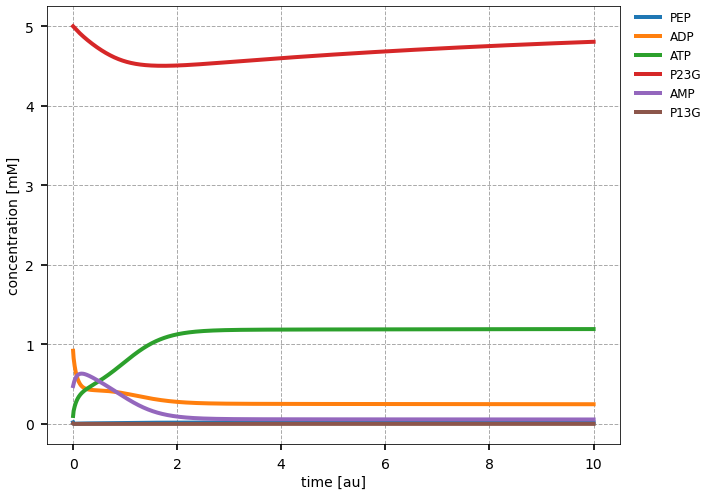

In [13]:
s = Simulator(m)
s.initialise(y0)
t, y = s.simulate(t_end=10, steps=1000)
fig, ax = s.plot(xlabel='time [au]', ylabel='concentration [mM]')
plt.show()

In [14]:
t_ss, y_ss = s.simulate_to_steady_state()

compounds_list = m.get_compounds()

summe = 0

for i in range(len(compounds_list)):
    print('{comp:<4s}:  {value:.5f} [au]'.format(comp = compounds_list[i], value = y_ss[0, i]))
    summe = summe + y_ss[0, i]

PEP :  0.01807 [au]
ADP :  0.24367 [au]
ATP :  1.19863 [au]
P23G:  5.01375 [au]
AMP :  0.05370 [au]
P13G:  0.00050 [au]


In [15]:
# get fluxes

flxs = s.get_fluxes_df()
flxs

,v_HK_PFK,v_P2GM,v_P2Gase,v_PGK,v_PK_LDH,v_AK,v_ATPase
0.00,0.026678,7.498062,0.749930,72.204036,10.461546,-3.479685e+00,0.145984
0.01,0.070772,0.013134,0.748954,0.127949,0.932700,-2.639866e+00,0.237856
0.02,0.099372,0.020427,0.747856,0.177809,0.902436,-2.183777e+00,0.281948
0.03,0.127716,0.028350,0.746771,0.226539,0.948766,-1.813126e+00,0.319787
0.04,0.155226,0.036676,0.745699,0.273215,0.994203,-1.507298e+00,0.352746
...,...,...,...,...,...,...,...
9.97,1.255321,0.744523,0.720596,1.766118,2.486670,2.425274e-04,1.741208
9.98,1.255316,0.744532,0.720632,1.766100,2.486687,2.422385e-04,1.741218
9.99,1.255311,0.744540,0.720668,1.766081,2.486705,2.419500e-04,1.741228
10.00,1.255306,0.744549,0.720704,1.766063,2.486722,2.416618e-04,1.741238
